Skip connections, also known as residual connections, are a key architectural component in ResNets. They were introduced to address the problem of vanishing gradients during training deep neural networks. Here's why skip connections are important in ResNets:


1.   Mitigating Vanishing Gradients: As you train deep neural networks, the gradients can become very small as they are backpropagated through the layers. When gradients become too small, it's challenging for the model to learn effectively, and training may become slow or stall altogether. Skip connections mitigate this problem by allowing gradients to flow directly through shortcut connections. This ensures that gradients don't vanish as quickly, making it easier to train very deep networks.
2.   Enabling Training of Extremely Deep Networks: Before ResNets, it was difficult to train very deep neural networks (e.g., with 100+ layers) effectively. Skip connections allow the network to be extremely deep while still maintaining good training dynamics.
3.   Easier Optimization: Skip connections make it easier for optimization algorithms like stochastic gradient descent (SGD) to find good solutions in the parameter space.
4.   Improved Generalization: Skip connections can improve the generalization performance of neural networks. The network can learn both fine-grained details from shallow layers and high-level abstractions from deeper layers simultaneously.


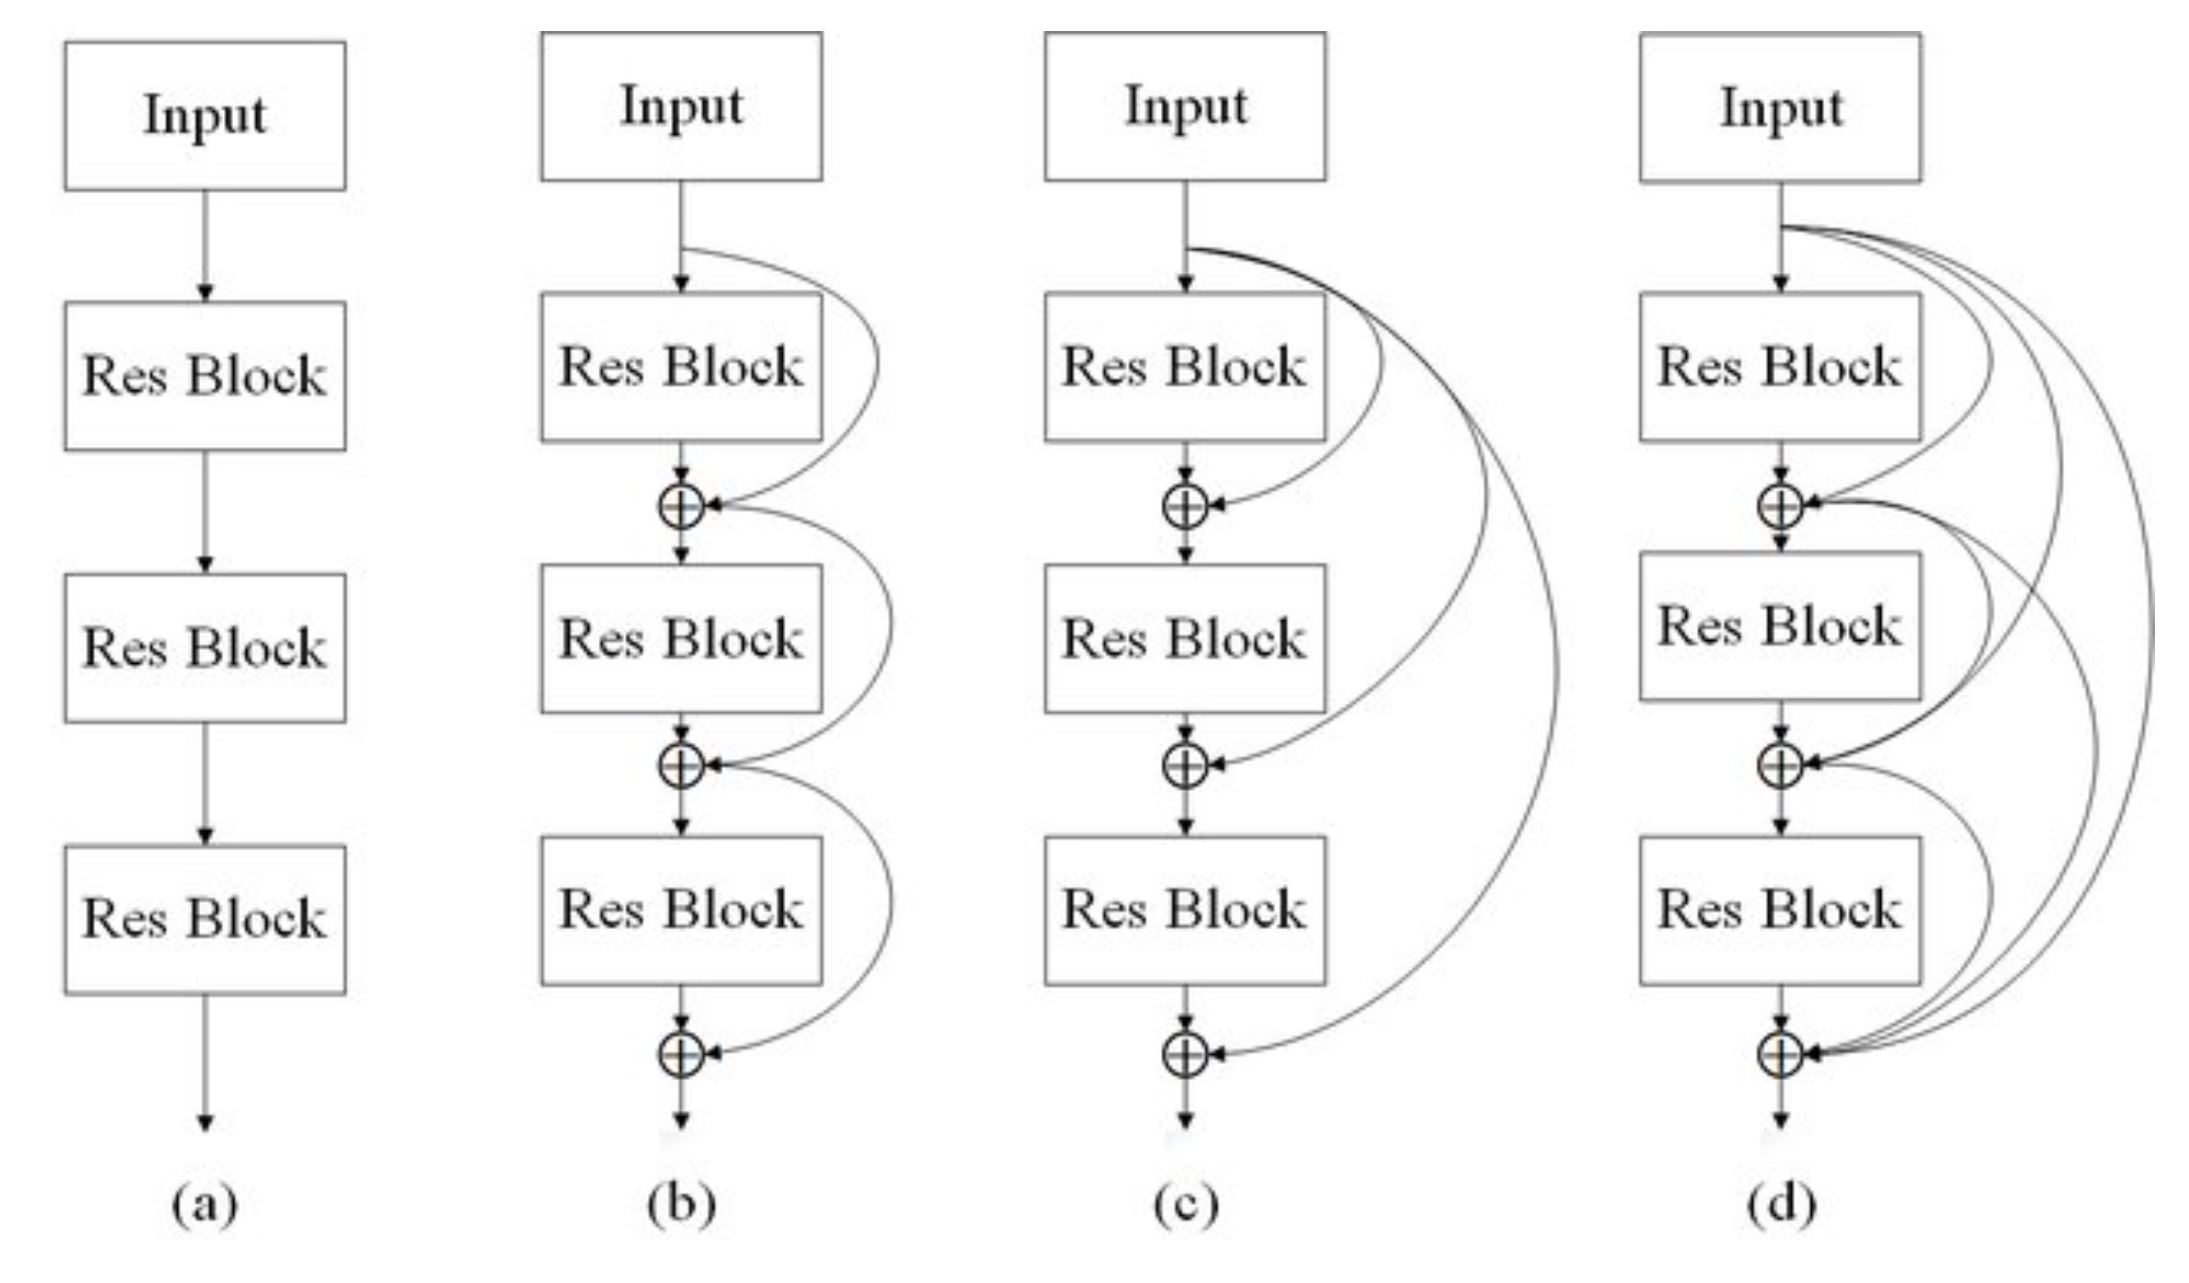



Mini-batch related questions: https://github.com/FrancescoSaverioZuppichini/Tensorflow-Dataset-Tutorial/blob/master/dataset_tutorial.ipynb

**What is the Difference Between Steps and Epochs?**

The main difference between steps and epochs is that epochs refer to the number of times the model sees the entire training dataset, while steps refer to the number of batches processed during training.

For example, suppose you have a training dataset of 10,000 images, and you set the batch size to 100. In that case, each epoch will consist of 100 batches, with each batch containing 100 images. Therefore, to complete one epoch, the model will process 100 batches, each with 100 images, resulting in 10,000 images seen by the model.

Suppose you set the number of steps to 1000 and the batch size to 10. In that case, the model will process 10 images in each batch, resulting in 10,000 images seen by the model after 1000 steps

# Transfer Learning

(or Green Deep Learning!)

What is transfer learning?
Transfer learning (TL) is a technique in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different problem.

We start from a pre-trained model which is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You can either use the pretrained model as is or use transfer learning to customize this model to a given task!


Why use it?
- Minimize training time
- Lower emissions
- More powerful feature extractors

![title](https://ekamperi.github.io/images/compute_diagram.png)
https://developer.nvidia.com/blog/training-bert-with-gpus/

![title](https://ekamperi.github.io/images/nvidia_training.jpg)

https://developer.nvidia.com/blog/training-bert-with-gpus/

![title](https://ekamperi.github.io/images/footprint_comparison.png)


### Costs:
- 2.5k – 50k USD (110 million parameter model)
- 10k – 200k USD(340 million parameter model)
- 80k – 1.6m USD (1.5 billion parameter model)
source: syncedreview.com


Here we will try two ways to customize a pretrained model:

1. Feature Extraction (als covered in last tutorial)
2. Fine-Tuning

Let's get started

In [1]:
!pip install --upgrade tensorflow matplotlib

  Using cached tensorflow-2.18.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached matplotlib-3.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.12.23-py2.py3-none-any.whl.metadata (876 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.69.0-cp310-cp310-macosx_12_0_universal2.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached h5py-3.12.1-cp310-cp310-macosx_11_

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=0'

In [3]:
#downloading the data
# We will use a dataset containing several thousand images of cats and dogs
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True, cache_dir='./')
PATH = os.path.join('./datasets', 'cats_and_dogs_extracted/cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [4]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


2025-01-09 10:18:23.019928: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


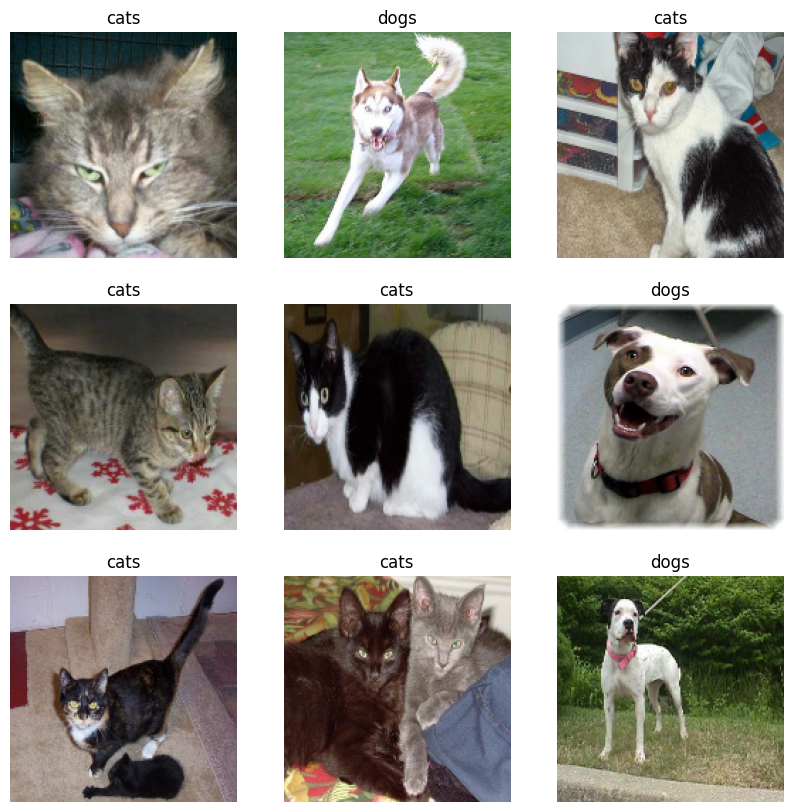

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
#The dataset does not have a test set so ww will use 20% of the valudation set into testing
#Training is 2000 and validation is 1000 (too large for validation only!)

#Only run once
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [8]:
#Use buffered prefetching to load images from disk without having I/O become blocking
#https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
#When you don't have a large image dataset,
#it's a good practice to artificially introduce sample diversity by applying random,
#yet realistic, transformations to the training images,
#such as rotation and horizontal flipping.
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),]
)

2025-01-09 10:18:23.533507: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


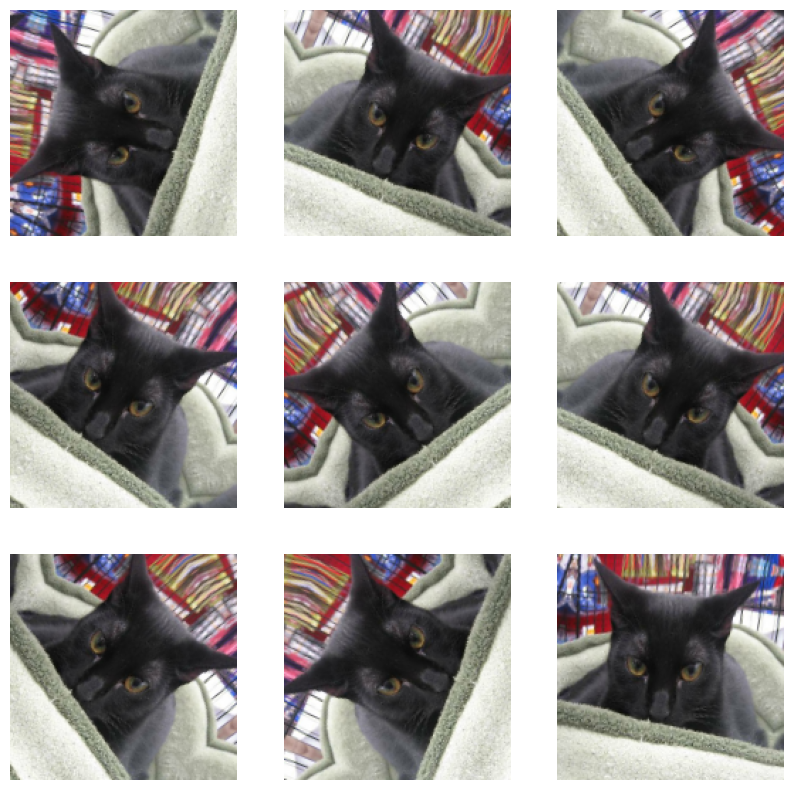

In [10]:
#Let's repeatedly apply these layers to the same image and see the result.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
#Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [12]:
# Create the base model from the pre-trained model MobileNet V2 developed at Google
# https://arxiv.org/pdf/1704.04861.pdf
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

# 32 = batch size

(32, 5, 5, 1280)


image_batch, label_batch = next(iter(train_dataset)): Obtain a single batch of data (both images and their corresponding labels) from the train_dataset. It assumes that you have an iterator for the dataset (achieved through iter(train_dataset)), and it assigns the batch of images to image_batch and the batch of labels to label_batch.

feature_batch = base_model(image_batch): In this line, you're passing the image_batch through a pre-trained base model. The base_model is likely a pre-trained deep neural network (e.g., a convolutional neural network like VGG, ResNet, etc.) that has been loaded and configured for feature extraction. By passing the images through this model, you're obtaining a batch of feature vectors for the images. These feature vectors represent the learned high-level representations of the images within the neural network's layers.

print(feature_batch.shape): print the shape of the feature_batch. This will give you information about the dimensions of the feature vectors produced by the base model for the current batch of images. The shape will typically be in the format (batch_size, num_features), where batch_size is the number of images in the batch, and num_features is the number of features extracted by the base model for each image.

In [14]:
#Freeze the convolutional base (you are not fine tuning here)
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
#Apply a tf.keras.layers.Dense layer to convert these features
#into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API.

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compile the model before training it

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Note: The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer!

In [21]:
len(model.trainable_variables)

2

Let's see the validation performance before training!

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5555 - loss: 0.6965


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.56


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.6079 - loss: 0.6416 - val_accuracy: 0.7191 - val_loss: 0.4728
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.7345 - loss: 0.4842 - val_accuracy: 0.8181 - val_loss: 0.3461
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.7865 - loss: 0.4024 - val_accuracy: 0.8911 - val_loss: 0.2663


Let's now look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor!

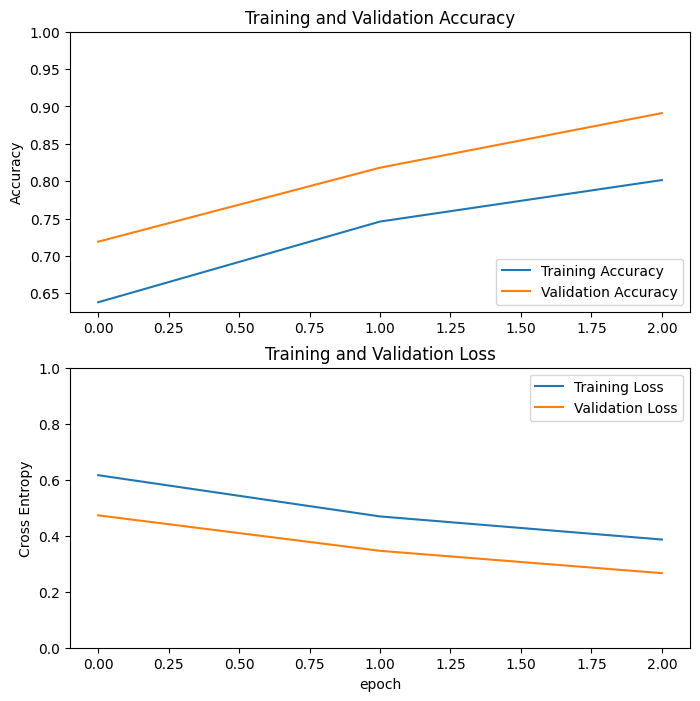

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine-tuning!

In the feature extraction experiment, you were only training a few layers on top (classification layers) of an MobileNet V2 base model. The weights of the (CNN part)pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added.


Let's un-freeze the top layers of the model!

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,041,281 (3.97 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

Note: number of trainable paramters now jumped to ~1.

What's the none-trainable prameters?
Other paramters associated with the model:
- Input shape
- The number of hidden layers itself
- Nodes on each hidden layer
- Statistics in BatchNormalization layers and other operation layers
- any paramter not updated by gradient descent!

In [30]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 3/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.8504 - loss: 0.3890 - val_accuracy: 0.9394 - val_loss: 0.1347
Epoch 4/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8942 - loss: 0.2678 - val_accuracy: 0.9554 - val_loss: 0.0968
Epoch 5/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.9197 - loss: 0.2082 - val_accuracy: 0.9579 - val_loss: 0.0820
Epoch 6/6
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9186 - loss: 0.1875 - val_accuracy: 0.9678 - val_loss: 0.0679


We see the difference now!


Let's check the validation accuracy!

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Let's visulize the before and after fine-tuning perfromance!

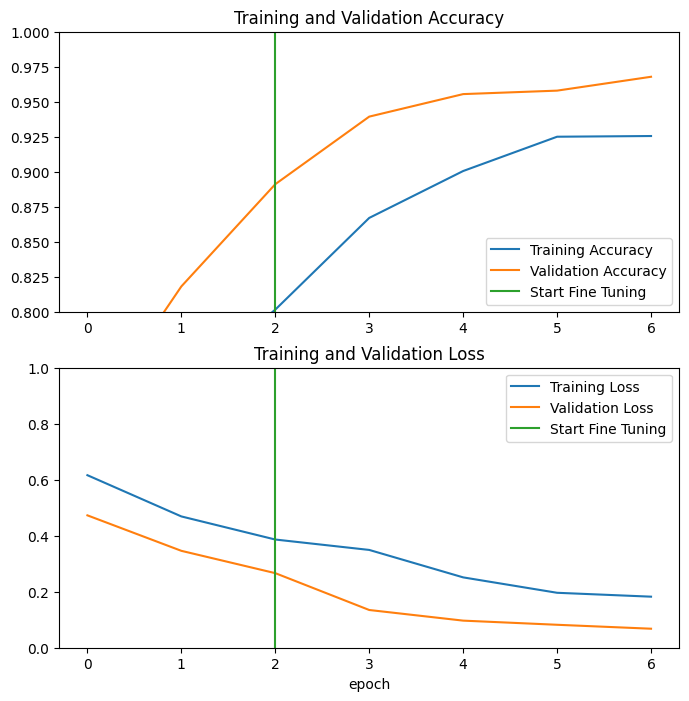

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Finaly let's look at the test performance

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9742 - loss: 0.0730
Test accuracy : 0.9635416865348816


The model is now ready for predicting if your pet is a cat or dog.

Predictions:
 [0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0]
Labels:
 [0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0]


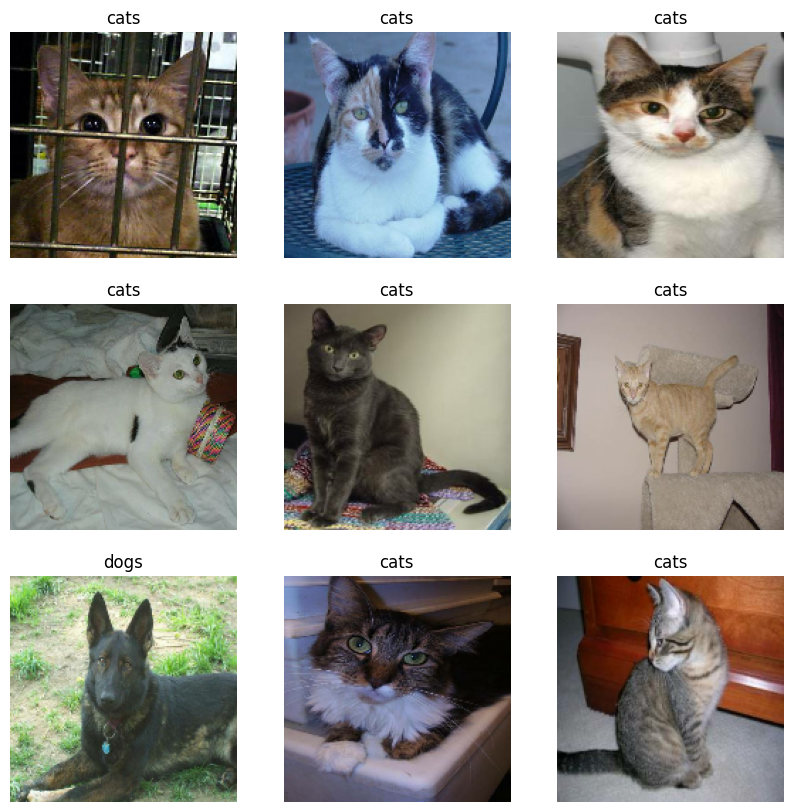

In [34]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Part 2: Transfer learning with TensorFlow Hub

Instead of being  limited to keras applications https://www.tensorflow.org/api_docs/python/tf/keras/applications. The TensorFlow Hub lets you search and discover hundreds of trained, ready-to-deploy machine learning models in one place!


Let's demonstrate its use!

In [35]:
#Just in case you need to download it!
!pip install tensorflow tf_keras tensorflow-hub


  Using cached tf_keras-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.5 MB/s eta 0:00:00
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)


In [36]:
#Setup
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Let's start with ImageNet by using a pretrained classifer model to take an image and predict what it's an image of - no training required!

In [37]:
IMAGE_SHAPE = (224, 224)
model_url='https://tfhub.dev/tensorflow/efficientnet/b0/classification/1'
classifier = keras.Sequential([
    hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE + (3,))
])

Download a single image to apply the model on

61306/61306 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


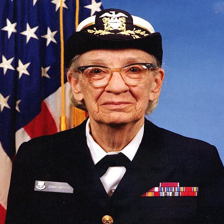

In [38]:
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [39]:
#Manual normalization
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [40]:
#Add a batch dimension, and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 378ms/step


(1, 1000)

In [41]:
predicted_class = np.argmax(result[0], axis=-1)+1
predicted_class

653

In [42]:
#Take the predicted class ID and fetch the ImageNet labels to decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

10484/10484 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


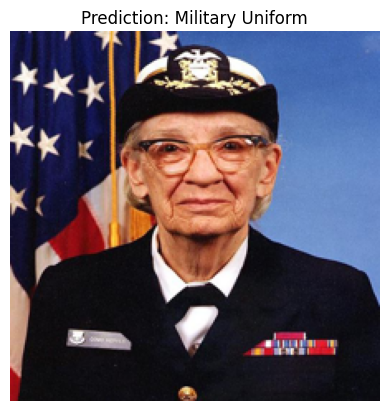

In [43]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Full example
What if you want to train  transfer learninga classifier for a dataset with different classes?

In [44]:
#Let's download the data
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [45]:
#Let's load this data into our model using images off disk using image_dataset_from_directory.

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 1 classes.
Using 2936 files for training.


In [46]:
#We have five different flower classes
class_names = np.array(train_ds.class_names)
print(class_names)

['flower_photos']


In [47]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [48]:
# Let's no make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking.
# These are two important methods you should use when loading data.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2025-01-09 10:20:00.259505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [50]:
# Run classifier
#NOTE: It takes some time!
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 23s 243ms/step


In [51]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['rapeseed', 'pop bottle', 'scuba diver', ..., 'rapeseed',
       'rapeseed', 'bell pepper'], dtype='<U30')

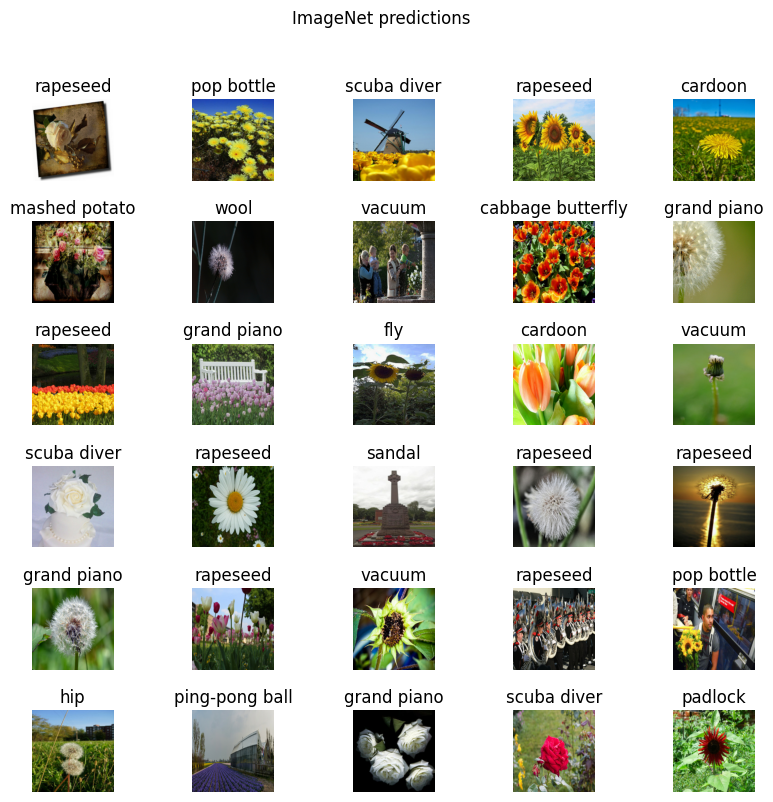

In [52]:
#Now check how these predictions line up with images
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [53]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [54]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [55]:
#It returns a 1280-length vector of features for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [56]:
# Let's wrap the model layer in a tf.keras.Sequential model,
# and add a new classification layer!
num_classes = len(class_names)

model = keras.Sequential([
  feature_extractor_layer,
  keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Note: we are freezing feature extraction layers here too!

In [57]:
predictions = model(image_batch)

In [58]:
predictions.shape

TensorShape([32, 1])

In [59]:
#Let's train the model
model.compile(
  optimizer=keras.optimizers.Adam(),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [60]:
# Helper functions to visulize the training progress

class CollectBatchStats(keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=2,
                    callbacks=[batch_stats_callback])

Epoch 1/2
92/92 [==============================] - 13s 128ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/2
92/92 [==============================] - 13s 136ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


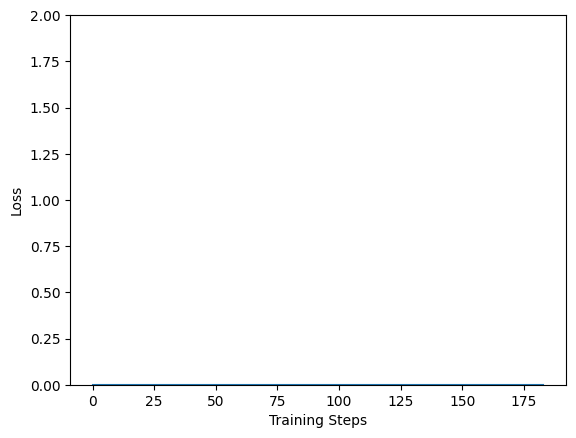

In [61]:
# Let's check the progress on the loss
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

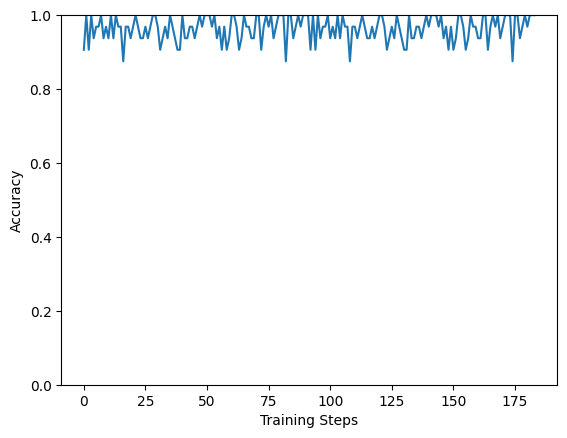

In [62]:
# Let's check the progress on the accuracy
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [63]:
# Let's check the predictions now

predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

1/1 [==============================] - 0s 346ms/step


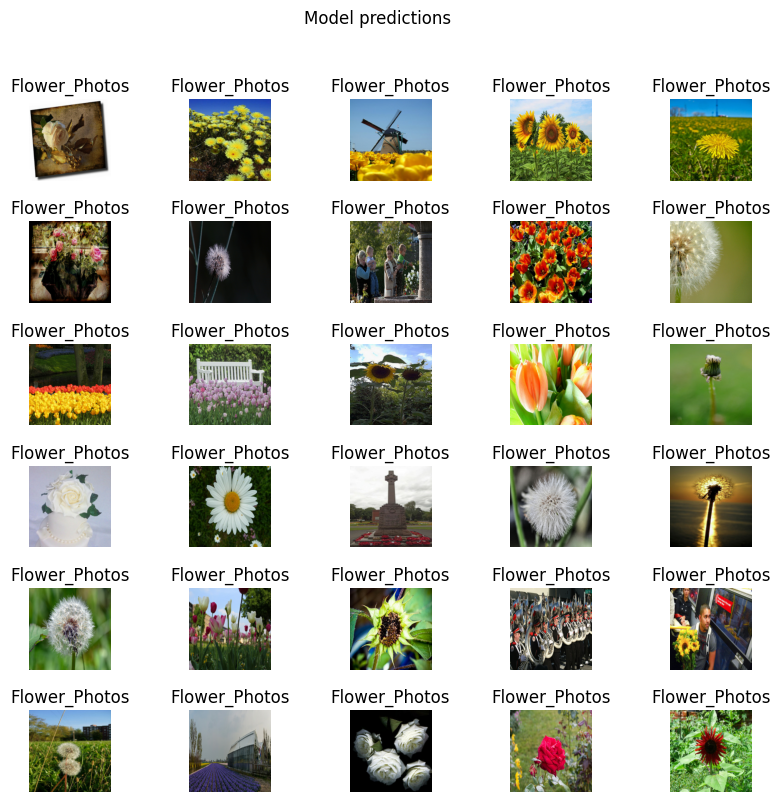

In [64]:
# plot

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

References:
    - François Chollet
    - https://www.tensorflow.org/